In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [45]:
trips = pd.read_csv("data/202001-capitalbikeshare-tripdata.csv", parse_dates = [1,2])
locations = pd.read_csv('data/Capital_Bike_Share_Locations.csv')

# finally, change column names that has spaces in it because it's difficult to code strings in same cases
trips.columns = [col.replace(' ', '_', -1) for col in trips.columns.values]
trips.describe()

In [46]:
trips.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,506,2020-01-01 00:00:59,2020-01-01 00:09:26,31623,Columbus Circle / Union Station,31658,Rosedale Rec Center,W22189,Member
1,1050,2020-01-01 00:01:16,2020-01-01 00:18:47,31613,Eastern Market Metro / Pennsylvania Ave & 7th ...,31606,Potomac & Pennsylvania Ave SE,W21067,Member
2,1687,2020-01-01 00:02:42,2020-01-01 00:30:50,31218,L'Enfant Plaza / 7th & C St SW,31271,Constitution Ave & 2nd St NW/DOL,W24359,Member
3,182,2020-01-01 00:02:44,2020-01-01 00:05:47,31627,3rd & M St NE,31508,Gallaudet / 8th St & Florida Ave NE,W23334,Member
4,1002,2020-01-01 00:06:12,2020-01-01 00:22:54,31247,Jefferson Dr & 14th St SW,31274,10th & G St NW,W23441,Member


In [4]:
s1 = trips['Start station number'].unique()
s2 = trips['End station number'].unique()
s3 = locations['TERMINAL_NUMBER'].unique()

print("in trips start but not in locations: %s" % set(s1).difference(set(s3)))
print("in trips end but not in locations: %s" % set(s2).difference(set(s3)))
print("in locations but not in trips start: %s" % set(s3).difference(set(s1)))
print("in locations but not in trips end: %s" % set(s3).difference(set(s2)))

in trips start but not in locations: {0, 31202}
in trips end but not in locations: {0, 31202}
in locations but not in trips start: {32901, 32072, 32015, 32209, 32211, 32023, 32030}
in locations but not in trips end: {32225, 31714, 32901, 32072, 32015, 31823, 32208, 32211, 32212, 32409}


station 0 @ 22nd & H NW (disabled) is disabled. Data for station 31202 @ 14th and R can be manually added.

In [47]:
station_is_0 = trips[(trips['Start station number'] == 0) | (trips['End station number'] == 0)].index
trips.drop(station_is_0, axis=0, inplace=True)

locations['capacity'] = locations['NUMBER_OF_EMPTY_DOCKS'] + locations['NUMBER_OF_BIKES']
to_keep = ["TERMINAL_NUMBER", "LATITUDE", "LONGITUDE", 'capacity']
locations = locations[to_keep] 
locations.loc[locations.shape[0], :] = [31202 , 38.912638, -77.032008]

In [48]:
# merge trips data to locations data twice for start station and end station
df = pd.merge(trips, locations[to_keep], how = 'left', left_on = 'Start station number', 
              right_on = 'TERMINAL_NUMBER')
df = pd.merge(df, locations[to_keep], how = 'left', left_on = 'End station number', 
              right_on = 'TERMINAL_NUMBER', suffixes = ('_start', '_end'))
df.drop(['TERMINAL_NUMBER_start', 'TERMINAL_NUMBER_end'], axis = 1, inplace=True)

In [72]:
# distance
# euclidean distance between start and end stations 
df['distance'] = np.sqrt(np.square((df.LATITUDE_end - df.LATITUDE_start)*111) + 
                         np.square((df.LONGITUDE_end - df.LONGITUDE_start)*85))


# various date labels
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(min(df['Start_date']), max(df['Start_date']))

df['date'] = df['Start_date'].dt.date
df['day'] = df['Start_date'].dt.dayofweek
df['hour'] = df['Start_date'].dt.hour
df['week'] = df['Start_date'].dt.week
df['holiday'] = df['date'].isin(holidays)
df['weekend'] = df['day'].isin([6, 7])
    
df.head()

,Duration,Start_date,End_date,Start_station_number,Start_station,End_station_number,End_station,Bike_number,Member_type,LATITUDE_start,LONGITUDE_start,LATITUDE_end,LONGITUDE_end,distance,date,day,holiday,weekend,hour,week
0,506,2020-01-01 00:00:59,2020-01-01 00:09:26,31623,Columbus Circle / Union Station,31658,Rosedale Rec Center,W22189,Member,38.896960,-77.004930,38.897808,-76.979634,2.152219,2020-01-01,2,False,False,0,1
1,1050,2020-01-01 00:01:16,2020-01-01 00:18:47,31613,Eastern Market Metro / Pennsylvania Ave & 7th ...,31606,Potomac & Pennsylvania Ave SE,W21067,Member,38.884000,-76.995397,38.880300,-76.986200,0.883063,2020-01-01,2,False,False,0,1
2,1687,2020-01-01 00:02:42,2020-01-01 00:30:50,31218,L'Enfant Plaza / 7th & C St SW,31271,Constitution Ave & 2nd St NW/DOL,W24359,Member,38.886266,-77.022241,38.892275,-77.013917,0.972369,2020-01-01,2,False,False,0,1
3,182,2020-01-01 00:02:44,2020-01-01 00:05:47,31627,3rd & M St NE,31508,Gallaudet / 8th St & Florida Ave NE,W23334,Member,38.905470,-77.002130,38.905090,-76.994100,0.683852,2020-01-01,2,False,False,0,1
4,1002,2020-01-01 00:06:12,2020-01-01 00:22:54,31247,Jefferson Dr & 14th St SW,31274,10th & G St NW,W23441,Member,38.888553,-77.032429,38.898243,-77.026235,1.197533,2020-01-01,2,False,False,0,1


In [8]:
def print_unique_values(df, show_limit = 20):
    for col in df.columns:
        if df[col].dtypes == 'O':
            unique_values = df[col].unique()
            if len(unique_values) > show_limit:
                print("%s : %s unique values" % (col, len(unique_values)))
            else:
                print("%s : \n%s" % (col, df[col].value_counts()))
            print('---------------------')

print_unique_values(df)

Start date : 182940 unique values
---------------------
End date : 182607 unique values
---------------------
Start station : 573 unique values
---------------------
End station : 570 unique values
---------------------
Bike number : 4773 unique values
---------------------
Member type : 
Member    185764
Casual     10618
Name: Member type, dtype: int64
---------------------


In [9]:
# finally, change column names that has spaces in it because it's difficult to code strings in same cases
df.columns = [col.replace(' ', '_', -1) for col in df.columns.values]
df.describe()

,Duration,Start_station_number,End_station_number,LATITUDE_start,LONGITUDE_start,LATITUDE_end,LONGITUDE_end,distance
count,196382.000000,196382.000000,196382.000000,196382.000000,196382.000000,196382.000000,196382.000000,196382.000000
mean,818.016987,31345.888422,31347.369891,38.904214,-77.032497,38.902563,-77.032307,1.701983
std,1763.464634,240.083686,238.145607,0.026297,0.031147,0.025684,0.030657,1.189183
min,60.000000,31000.000000,31000.000000,38.782633,-77.368416,38.782633,-77.368416,0.000000
25%,351.000000,31202.000000,31211.000000,38.894573,-77.044400,38.894514,-77.044600,0.874761
50%,574.000000,31266.000000,31266.000000,38.903040,-77.032224,38.902204,-77.032112,1.422141
75%,932.000000,31602.000000,31603.000000,38.915400,-77.015970,38.912100,-77.015970,2.252253
max,86147.000000,32609.000000,32609.000000,39.126000,-76.825535,39.126000,-76.825535,22.448789


# Explaratory Data Analysis

    * Basic facts
        - Number of trips
        - Number of stations
        - Number of bikes
    * Broken out by:
        - Rider type
        - Time of the trip
        - Duration
        - Stations
        - Routes
    * Understanding demand
        - 
    * Over time:
        - Usage over time
        - Station expansion over time
        
## Basic Facts

To do:
    download all historical data

In [231]:
print("Number of trips in Jan 2020: {:,}".format(df.shape[0]))

Number of trips in Jan 2020: 196,382


In [236]:
print("Number of stations with usage > 0: {:,}".format(len(list(set(s1).union(set(s2)).intersection(s3)))))

Number of stations with usage > 0: 575


Capital Bikeshare has a pricing scheme where the first 30 mins is free for members and a some price for casual riders, and the price goes up exponentially every 30 mins. For instance, for memebrs who pay a monthly fee, the first 30 mins is \\$0, the second 30 mins \\$2, the next 30 mins \\$4, and \\$8 for every additional 30 mins

Let's create a catagorical field based on this. 

In [13]:
cutoffs = [0, 30*60, 60*60, 90*60, np.Inf]
df['Duration_cat'] = pd.cut(df.Duration, cutoffs, right = False)

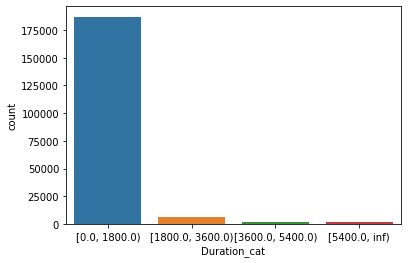

In [16]:
sns.countplot(x = 'Duration_cat', data = df)

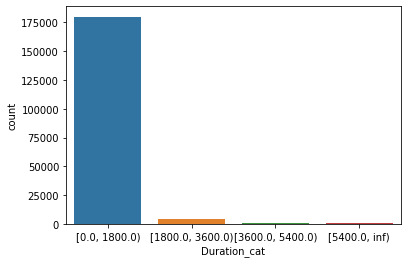

In [19]:
sns.countplot(x = 'Duration_cat', data = df.query('Member_type == "Member"'))

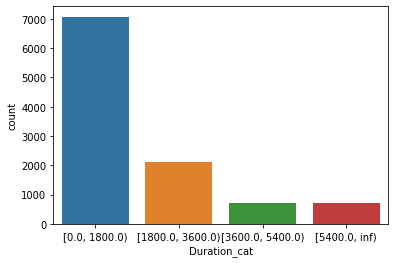

In [20]:
sns.countplot(x = 'Duration_cat', data = df.query('Member_type == "Casual"'))

It makes sense casual riders bike for longer time--they are likely tourists who doesn't know about the exponential pricing or are not sensitive to such pricing. The difference in average duration between the two groups are summarized in the next plot.

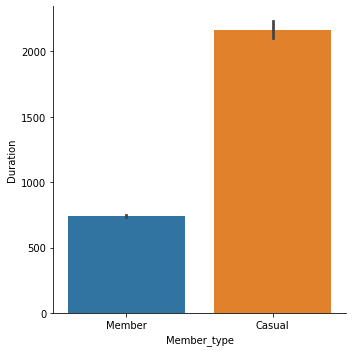

In [21]:
sns.catplot(data = df, x = 'Member_type', y = 'Duration', kind='bar')

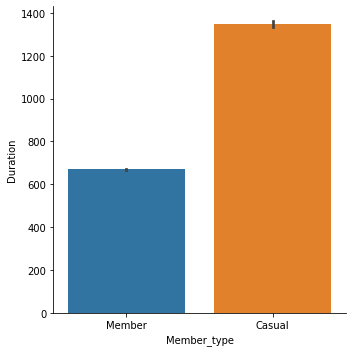

In [113]:
# but casual rider data seems to have a lot more extreme durations. What if I restrict to rides under 1 hours?
sns.catplot(data = df.query('Duration < 60*60'), x = 'Member_type', y = 'Duration', kind='bar')

Okay, there is still significant difference between the two.

# Average distance?

In [22]:
import googlemaps

How many unique start and end place? This determines number of requests

In [34]:
unique_stations_pairs = df.groupby(['Start_station_number', 'End_station_number']).size()
unique_stations_pairs.shape

(34158,)

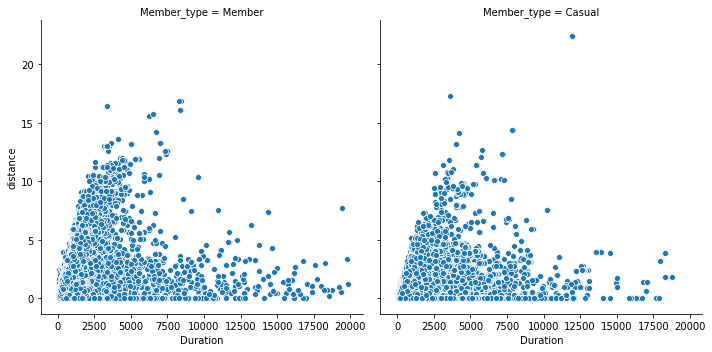

In [38]:
sns.relplot(x='Duration', y='distance', col = 'Member_type', data = df.query('Duration < 20000'))

This shows a linear relationship between the Euclidean distance between the start and end stations and the duration of the trip, which makes sense, even if the actual distance traveled must be longer than the Euclidean. In fact, you can see that many bike as fast as they can (trips on the diagonal), but many also take longer routes or longer time (trips under the diagonals) 

# Time

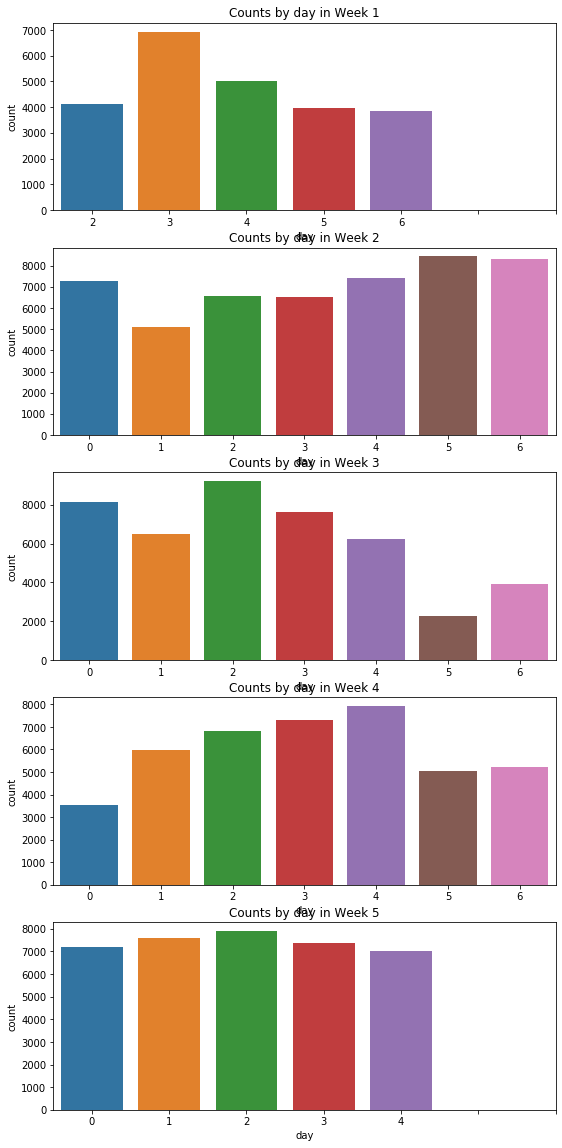

In [93]:
# Number of hours by day
weeks = df.week.unique()
fig, ax = plt.subplots(len(weeks), 1, figsize = (9, 20))
for week in weeks:
    sns.countplot(x='day', data=df[df.week == week], ax = ax[week-1])
    ax[week-1].set_title("Counts by day in Week " + str(week))
    ax[week-1].set_xticks(range(7))

Pretty different by week. 

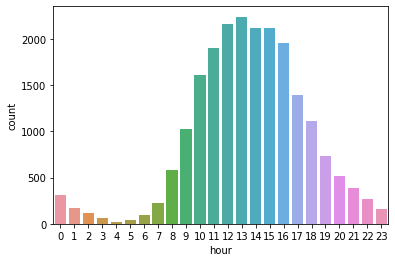

In [95]:
sns.countplot(x = 'hour', data = df[df.weekend])

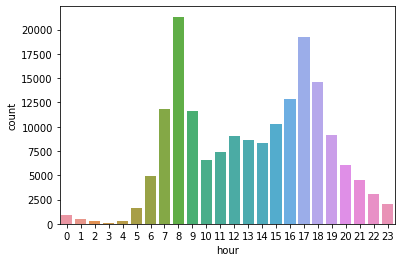

In [96]:
sns.countplot(x = 'hour', data = df[~df.weekend])

Usage spikes at hour 8 and 5 on weekdays, but is normally distributed on weekends.  

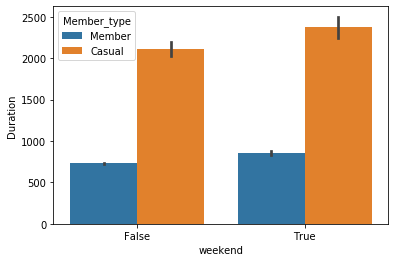

In [118]:
sns.barplot(x = 'weekend', y ='Duration', hue = 'Member_type', data=df)

Weekend rides tend to be slightly longer than weekday rides for both member and casual riders

In [125]:
locations.head()

,TERMINAL_NUMBER,LATITUDE,LONGITUDE
0,31015.0,38.894600,-77.072305
1,31016.0,38.893438,-77.076389
2,31017.0,38.891696,-77.084600
3,31018.0,38.892164,-77.079375
4,31706.0,38.865590,-76.952103


# Stations

In [160]:
# locations data frame has more locations than the terminals in trips data. 
#I think it's because some locations got shut down over time.
# filter locations to have only current terminals

current_terminals = list(set(trips.Start_station_number).union(set(trips.End_station_number)))
current_terminals
locations_df = locations[locations.TERMINAL_NUMBER.isin(current_terminals)]
print("%s stations dropped. Currently there are %s stations in use" % 
      (locations.shape[0]-locations_df.shape[0], locations_df.shape[0]))

4 stations dropped. Currently there are 576 stations in use


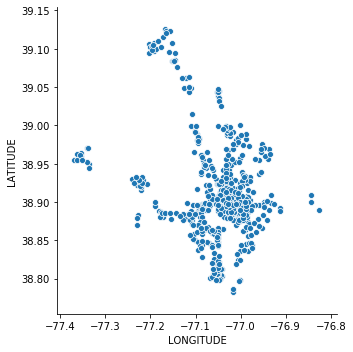

In [153]:
sns.relplot(x = 'LONGITUDE', y= 'LATITUDE', data=locations_df)

Good potential for analyzing the expansion of capital bike share for I download all trips data

What stations are in most demands?

In [180]:
start = df.groupby(['Start_station_number']).size().rename('start')
end = df.groupby(['End_station_number']).size().rename('end')

stations = pd.merge(start, end, 'outer', left_index=True, right_index=True)
# some start values and some end values (for different indices) will be NaN because
# some stations only started trips or ended trips. Replace with 0.
stations['start'] = stations['start'].fillna(0)
stations['end'] = stations['end'].fillna(0)
stations['usage'] = stations['start'] + stations['end']
stations = pd.merge(locations_df, stations, how = 'outer', 
                        left_on = 'TERMINAL_NUMBER',
                        right_index = True)

In [198]:
# bring the station addresses from trips data.
start_stations = trips[['Start_station_number', 'Start_station']].drop_duplicates()
start_stations.columns = ['station_number', 'address']
end_stations = trips[['End_station_number', 'End_station']].drop_duplicates()
end_stations.columns = ['station_number', 'address']

addresses = start_stations.append(end_stations).drop_duplicates()

In [199]:
stations = pd.merge(stations, addresses, how = 'left',
                   left_on = 'TERMINAL_NUMBER',
                   right_on = 'station_number')
stations.head()

,TERMINAL_NUMBER,LATITUDE,LONGITUDE,start,end,usage,log_usage,station_number,address
0,31015.0,38.894600,-77.072305,249.0,560.0,809.0,6.695799,31015,Rosslyn Metro / Wilson Blvd & Ft Myer Dr
1,31016.0,38.893438,-77.076389,290.0,297.0,587.0,6.375025,31016,Clarendon Blvd & Pierce St
2,31017.0,38.891696,-77.084600,260.0,148.0,408.0,6.011267,31017,Wilson Blvd & N Uhle St
3,31018.0,38.892164,-77.079375,134.0,93.0,227.0,5.424950,31018,Rhodes St & 16th St N
4,31706.0,38.865590,-76.952103,44.0,27.0,71.0,4.262680,31706,Fairfax Village


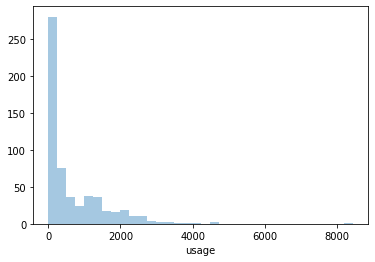

In [181]:
sns.distplot(stations.usage, kde=False)

The left-skewedness shows that huge number of stations don't have any contact (few trips started or ended from them) while a few stations have a disproportionate amount of contacts

Where are the most popular stations?

In [220]:
stations.sort_values('usage', ascending = False)[['station_number', 'usage', 'address']].head(10)

,station_number,usage,address
565,31623,8444.0,Columbus Circle / Union Station
477,31201,4655.0,15th & P St NW
554,31229,4543.0,New Hampshire Ave & T St NW
504,31603,4061.0,1st & M St NE
469,31101,3777.0,14th & V St NW
438,31124,3709.0,14th & Irving St NW
530,31613,3403.0,Eastern Market Metro / Pennsylvania Ave & 7th ...
503,31200,3269.0,Massachusetts Ave & Dupont Circle NW
9,31241,3238.0,Thomas Circle
478,31203,3206.0,14th & Rhode Island Ave NW


Least popular stations?

In [221]:
stations.sort_values('usage', ascending = False)[['station_number', 'usage', 'address']].tail(10)

,station_number,usage,address
142,32407,3.0,Oxon Hill Park & Ride
61,32221,3.0,Greensboro & International Dr
451,32208,2.0,Tysons West Transit Center
452,32209,2.0,North Shore & Cameron Crescent Dr/Crescent Apa...
320,32030,2.0,Broschart & Blackwell Rd
109,31715,2.0,37th & Ely Pl SE
126,32227,2.0,Greensboro & Pinnacle Dr
164,32409,1.0,Southern Ave Metro
160,31823,1.0,United Medical Center
91,32225,1.0,Reston Pkwy & Spectrum Dr


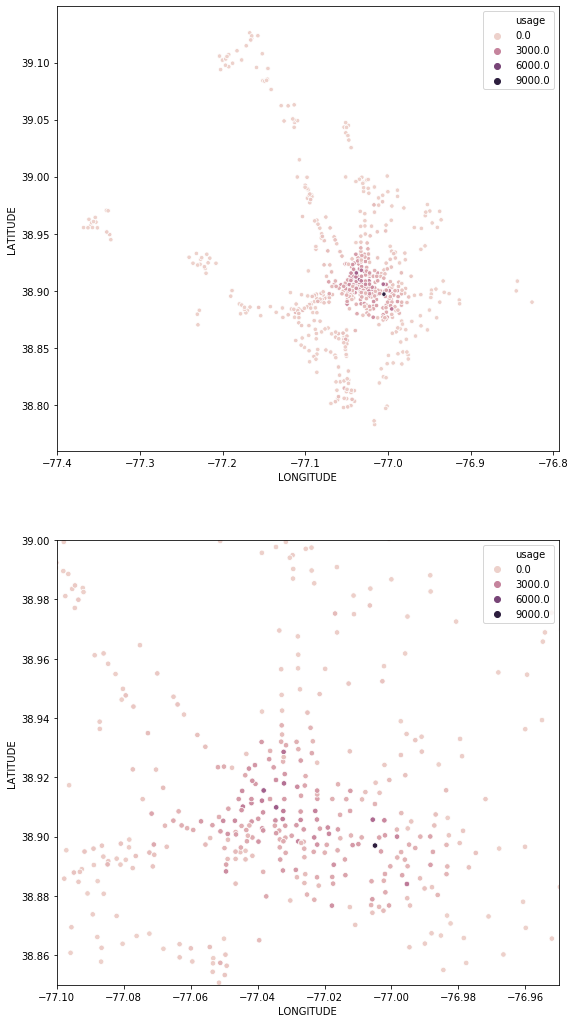

In [219]:
fig, ax = plt.subplots(2, 1, figsize=(9, 18))
sns.scatterplot(x = 'LONGITUDE', y= 'LATITUDE', hue= 'usage', data=stations, s=20, ax=ax[0])
ax[1].set(xlim=(-77.1, -76.95), ylim=(38.85, 39))
sns.scatterplot(x = 'LONGITUDE', y= 'LATITUDE', hue= 'usage', data=stations, s=30, ax=ax[1])

It's hard to tell (with this palette but probably with most palettes that goes from light to dark) because of the skewedness. 

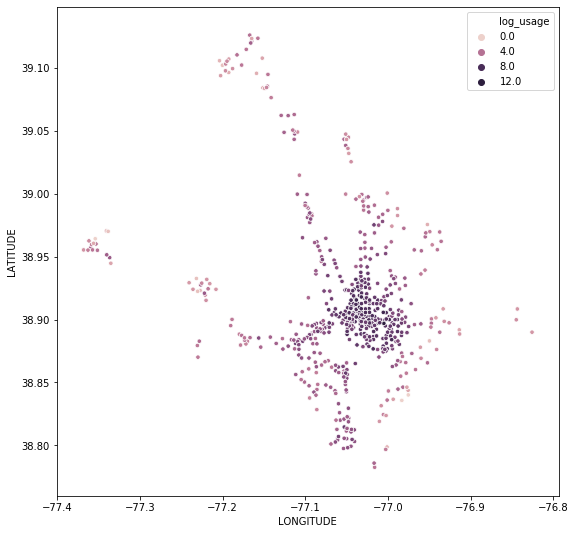

In [214]:
stations['log_usage'] = np.log(stations.usage)
fig, ax = plt.subplots(figsize=(9,9))
sns.scatterplot(x = 'LONGITUDE', y= 'LATITUDE', hue= 'log_usage', data=stations, s=20, ax=ax)

In [234]:
stations.shape

(576, 9)

# do users try to meet the time cutoff before the next (higher) price?

In [ ]:
# should be able to see the spike right before the cutoffs in the duration histogram
cutoffs = [0, 30*60, 60*60, 90*60]

fig, ax = pyplot.subplots(figsize=(11, 9))
g = sns.distplot(df.Duration[df.Duration < 90*60], kde=False, bins = np.linspace(0, 5400, 90), ax=ax)
g.set_xticks(cutoffs)

Fairly few people use the bikes over 30 mins. There doesn't seem to be a small drop at the first price hike at 30 mins.

In [ ]:
sns.catplot(data = df, x = 'Member_type', y = 'Duration', kind='bar')

confirms that casual riders (Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass) ride for way longer duration than members(Annual Member, 30-Day Member or Day Key Member)

In [ ]:
sns.countplot(data=df, x = 'Member_type')

Way more members than casual riders

In [ ]:
cutoffs = [0, 30*60, 60*60, 90*60]
bins = np.linspace(0, 5400, 90) # every minute

fig, ax = pyplot.subplots(figsize=(11, 9))
g = sns.distplot(df.Duration[(df.Duration < 90*60) & (df['Member_type'] == 'Member')], kde=False, bins = bins, ax=ax)
g.set_xticks(cutoffs)

In [ ]:
sns.relplot(x='distance', y='Duration', col = 'Member_type', data = df)

In [ ]:
2500/3600

In [ ]:
# Distribution of trip duration 
sns.distplot(df.Duration, kde = False)

There are some extreme outliers that affecting the scale of the distribution. How what observations have duration > 2hr?

In [ ]:
df.query('Duration > 7200')

In [ ]:
sns.distplot(df.query('Duration < 3600').Duration, kde = False)